# Residential Building Classification
This is a bare-bone version of the residential vs. non-residential building classification. We use DenseNet in this implementation. 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt

from cs231n.data_utils import *
from sampler import RandomSampler
import params
from densenet_efficient import DenseNetEfficient
from demo import train
from cs231n.dataset import *

# Load parameters
params = vars(params)
rbc_class_names = params['rbc_class_names']
fmow_class_names = params['fmow_class_names']
fmow_class_names_mini = params['fmow_class_names_mini']
dtype = params['dtype']

torch.set_num_threads(params['num_threads'])

## Preprocess FMOW Dataset
Check if fMoW dataset is available. If so, process the images by cropping based on given bounding boxes. Load in traing, validation and test dataset along with ground truth labels for training and validation set. 

In [3]:
mean = 0.5
stdv = 0.25
valid_size = 100
batch_size = 30
num_epochs = 50
learning_rate = 1e-4
print_every = 10

train_transforms = transforms.Compose([
    Normalize(mean=mean, std=stdv),
    Rescale((224,224)),
    ToTensor(),
])
train_set = FMOWDataset(params, transform=train_transforms)
x,y = train_set[0]
print(type(x), x.shape, type(y), y.shape)

indices = torch.randperm(len(train_set))
len(train_set)
train_indices = indices[:len(indices) - valid_size]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_indices = indices[len(indices) - valid_size:]
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)

loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                                   pin_memory=(torch.cuda.is_available()), num_workers=0)
loader_val = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler,
                                                   pin_memory=(torch.cuda.is_available()), num_workers=0)

<class 'torch.FloatTensor'> torch.Size([1, 224, 224]) <class 'torch.LongTensor'> torch.Size([1])


### Visualize a small batch of data
Plot a small batch of training images to get a sense of data

In [3]:
# Sample a minibatch and show the images and captions
mini_size = 5
indices = np.random.choice(X_test.shape[0], mini_size, replace=False)
for i, idx in enumerate(indices):
    plt.subplot(1, mini_size, i+1)
    img = np.moveaxis(X_test[idx, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_test[idx]])
    plt.show()

NameError: name 'X_test' is not defined

## Load Model
Load in pre-trained DenseNet. Configure training parameters. 

### Naive two-layer CNN

In [4]:
# CNN Model (3 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=6, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(13*13*32, len(rbc_class_names))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
#     224*224  
#     55*55
#     26*26
#     13*13

In [5]:
model = CNN().type(dtype)
model = model.cuda()
# model.load_state_dict(torch.load('cnn.pkl'))
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_history = []
train_acc_history = []
val_acc_history = []

## Train Model
Train the model one epoch at a time. Keep the verbose option on to monitor the loss during training. 
Save training and validation accuracy history for visualization. 

In [6]:
# Define Train function
def train(model, loss_fn, optimizer, loader_train, loader_val, epochs=1):
    for epoch in range(epochs):
        # Set on Training mode
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var[:,0])
            loss_history.append(loss.data[0])
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc_history.append(check_accuracy(model, loader_train))
        val_acc_history.append(check_accuracy(model, loader_val))
            
def check_accuracy(model, loader, num_limit=100):
    '''
    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
      classified by the model.
    '''
    num_correct = 0
    num_samples = 0
    # Put model in test mode
    model.eval() 
    # Compute predictions in batches to save memory
    for x, y in loader:
        x_var = Variable(x.type(dtype), volatile=True) 
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y[:,0]).sum()
        num_samples += preds.size(0)
        if num_samples >= num_limit:
            break
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc
 

In [7]:
# Train the model
train(model, loss_fn, optimizer, loader_train, loader_val, epochs=num_epochs)

t = 10, loss = 0.1530
t = 20, loss = 0.3375
t = 30, loss = 0.7205
t = 40, loss = 0.4228
Got 111 / 120 correct (92.50)
Got 89 / 100 correct (89.00)
t = 10, loss = 0.3235
t = 20, loss = 0.3615
t = 30, loss = 0.3576
t = 40, loss = 0.2436
Got 110 / 120 correct (91.67)
Got 89 / 100 correct (89.00)
t = 10, loss = 0.4807
t = 20, loss = 0.2097
t = 30, loss = 0.2269
t = 40, loss = 0.2956
Got 108 / 120 correct (90.00)
Got 89 / 100 correct (89.00)
t = 10, loss = 0.2854
t = 20, loss = 0.1419
t = 30, loss = 0.2273
t = 40, loss = 0.1649
Got 107 / 120 correct (89.17)
Got 89 / 100 correct (89.00)
t = 10, loss = 0.1393
t = 20, loss = 0.2365
t = 30, loss = 0.3657
t = 40, loss = 0.2155
Got 105 / 120 correct (87.50)
Got 89 / 100 correct (89.00)
t = 10, loss = 0.2027
t = 20, loss = 0.1340
t = 30, loss = 0.1268
t = 40, loss = 0.3133
Got 114 / 120 correct (95.00)
Got 89 / 100 correct (89.00)
t = 10, loss = 0.1330
t = 20, loss = 0.1726
t = 30, loss = 0.1113
t = 40, loss = 0.0569
Got 107 / 120 correct (89.17)


## Visualization
Visualize training and validation accuracy throughout training history. 
Visualize loss function. 

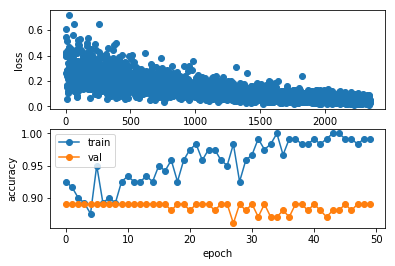

In [8]:
# Visualize loss history and training/validation accuracy history
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Test Model
Make predictions based on test dataset. Visually assess the quality of prediction and compute accuracy based on groundtruth. 

In [ ]:
# Check accuracy of model on Test set
test_acc = check_accuracy(model, loader_test)
print("Test Accuracy: %.3f" % test_acc)

### Visualize Successful and Failed Examples

In [ ]:
x = np.array([[1,2],[2,3],[3,4]])
mask = [False,False,True]
print(x)

In [ ]:
X_success = np.array([]).reshape((0, 1, 200, 200))
y_success = np.array([]).reshape((0,))
X_failure = np.array([]).reshape((0, 1, 200, 200))
y_failure = np.array([]).reshape((0,))

model.eval() 
for X, y in loader_test:
    X_var = Variable(X.type(dtype), volatile=True)
    scores = model(X_var)
    _, preds = scores.data.cpu().max(1)
    idx_success = (preds == y).numpy() == 1
    idx_failure = (preds != y).numpy() == 1
    X = X.numpy()
    y = y.numpy()
    X_success = np.append(X_success, X[idx_success.tolist(), :, :, :], axis=0)
    y_success = np.append(y_success, y[idx_success.tolist(), ], axis=0)
    X_failure = np.append(X_failure, X[idx_failure.tolist(), :, :, :], axis=0)
    y_failure = np.append(y_failure, preds[idx_failure.tolist(), ], axis=0)
    
y_success = y_success.astype(np.int32)
y_failure = y_failure.astype(np.int32)

In [ ]:
# Sample a batch of successfully classified images
for i in range(12):
    plt.subplot(3, 4, i+1)
    img = np.moveaxis(X_success[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_success[i]])
    plt.show()

In [ ]:
# Sample a batch of incorrectly classified images
plt.title('Failure Examples')
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = np.moveaxis(X_failure[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_failure[i]])
    plt.show()

## Save Model

In [ ]:
# Save the Trained Model
torch.save(model.state_dict(), 'cnn.pkl')